### Processes shared memory

Histrogram


In [1]:
%matplotlib notebook

import ctypes
import os
import multiprocessing as mp

import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d, gaussian

import astropy.io.fits as pf
import matplotlib.pyplot as plt
import time

In [9]:
img = pf.getdata("LB.20140623.37347.fits")

In [10]:
img.shape
flatImg = img.flatten()

In [11]:
#%%timeit
hgm = np.histogram (flatImg, bins=50, range=(1100, 1400))

<IPython.core.display.Javascript object>


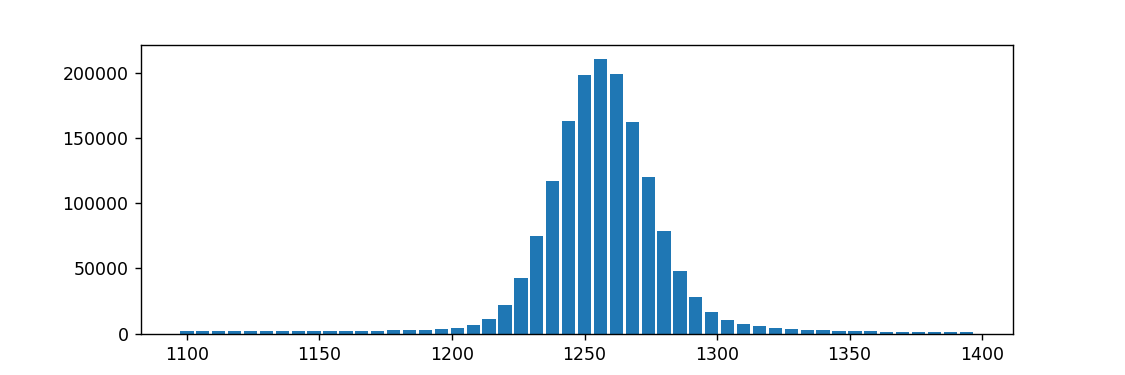

<Container object of 50 artists>

In [12]:
plt.figure(figsize=(9,3))
plt.bar(hgm[1][:-1], hgm[0], width=5)

In [7]:
def workerFunction (i):  
    global sharedBuffers, chunkSize, width
    idxFrom = i * chunkSize * width
    idxTo = idxFrom + chunkSize * width
    hgm = np.histogram (flatImg[idxFrom:idxTo], bins=bins, range=(1100, 1400))
    #print ("pid", os.getpid(), i)
    sharedBuffers[i][:] = hgm[0]

In [8]:
# Initialize sharedBuffers
bins = 50
height, width = img.shape
nParts = 1
chunkSize = img.shape[0] // nParts
sharedBuffers = []
for i in range(nParts):
    _buffer = mp.Array(ctypes.c_int, bins)
    sharedBuffers.append(np.ctypeslib.as_array(_buffer.get_obj()))

In [9]:
%%timeit
with mp.Pool(processes=nParts) as pool:
    pool.map (workerFunction, range(nParts))

158 ms ± 51.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
p = mp.Process(target=workerFunction, args=(0,))
p.start()
p.join()

130 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<Container object of 50 artists>

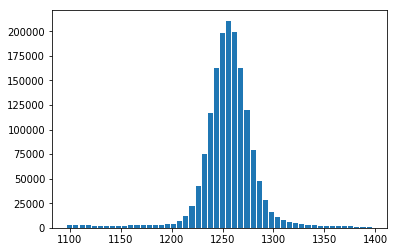

In [17]:
step = (1400-1100)//bins
stackedHg = np.sum(sharedBuffers, axis=0)
plt.bar (np.arange(1100, 1400, step), stackedHg, width=5)

In [ ]:
plt.imshow(img)